# Low price to FCF strategy evaluation

Is simply buying very low price to FCF (TTM) a good strategy?

By simply selecting lowest 10 stocks in price to FCF(TTM) ratio and hold it for 3 months, it seems to be consistently beating SPX. I applied some basic filtering:

1. Exclude REITs
2. Exclude stocks with negative FCF for any last 4 quarters
3. Exclude stocks whose most recent FCF is less than the average of last 4 quarters

But I doubt they are necessary.

Another finding is that compensate for growth doesn't seem necessary. I think it's because those stocks are so cheap that 20% growth won't change much. There may be marginal effect. But given the win over SPX is so big, it doesn't seem worthwhile to explore.

What's left is trying filtering by debt ratio, profitability, etc.

## Key Findings
* Ultra low price to FCF(TTM) stocks are consistently beating SP500, yearly beat is ~10% to 20%.
* Buy and hold low price to FCF(TTM) stocks is a left side strategy. Most of them won't have big discrepancy with SP500, but when they do, they are almost always super winners, like 2x to 6x higher return than SP500. Therefore, it will be very profitable if we can filter out losers/winers. Hence the machine learning idea.

## Intuition

Value, momentum, profitability, and growth may indeed has prediction power. However, it looks like it's easier to use them as filters rather than "scalers." That means just randomly choose stocks that meet a list of binary criteria, rather than ranking them.

# Future works

* Can we filter out losers by machine learning?
    - Use some manual features like big price drop/hike recently
* What will be the result of full backtesting, e.x. just keep all ultra low price to FCF stocks in the portfolio forever?
* Are there other intuitive and simple strategies, like momentum, profitability, alone?


In [1]:
from research.interday_trading import InterdayTrading
from fmp_data import Dataset, FMPPriceLoader
from tqdm import tqdm, trange
pl = FMPPriceLoader()
t = InterdayTrading('2024-01-02', '2024-01-15')

# Distribution of Price to FCF on one day's sample

2025-04-26 11:44:50,501 - Fetching price data for 5389 stocks on 2022-04-05


2025-04-26 11:44:50,825 - Retrieved prices for 4888 stocks
2025-04-26 11:44:50,826 - Calculating price-to-FCF ratios
2025-04-26 11:44:50,870 - Calculating revenue growth metrics
2025-04-26 11:44:58,168 - Calculating price momentum metrics
2025-04-26 11:44:58,169 - Calculating price momentum for 5389 stocks
2025-04-26 11:44:58,800 - Calculated price momentum for 4406 stocks
2025-04-26 11:44:58,801 - Calculating profit margin metrics
2025-04-26 11:45:03,901 - Merging feature data
2025-04-26 11:45:03,906 - Adding sector and industry information


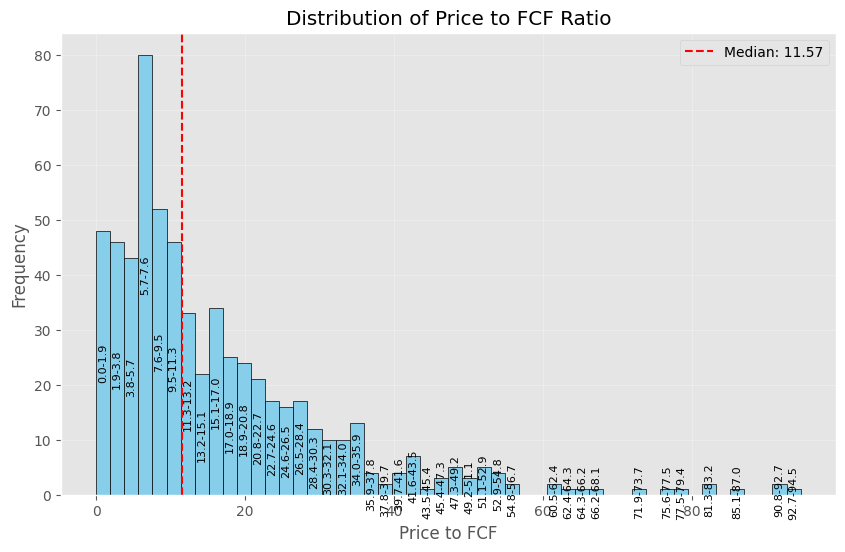

In [26]:
plt.figure(figsize=(10, 6))

start_date = '2022-04-05'


d = t.build_features_for_date(pd.to_datetime(start_date).date())
x = d
x = d[~d['industry'].str.contains('REIT', case=False, na=False)]
x = x[(x.min_fcf > 0) & (x.last_fcf > x.free_cash_flow / 4)]



n, bins, patches = plt.hist(x[x.price_to_fcf < 100].price_to_fcf, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=x.price_to_fcf.median(), color='red', linestyle='--', label=f'Median: {x.price_to_fcf.median():.2f}')

# Add text labels showing the range for each bar
for i in range(len(patches)):
    if n[i] > 0:  # Only add text if the bar has data
        plt.text(bins[i] + (bins[i+1]-bins[i])/2, n[i]/2, 
                 f'{bins[i]:.1f}-{bins[i+1]:.1f}', 
                 ha='center', va='center', rotation=90, fontsize=8)

plt.title('Distribution of Price to FCF Ratio')
plt.xlabel('Price to FCF')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Very low price to FCF group has higher returns

I sampled 1000 days between 2009-01-01 and 2023-10-01, buying stocks and holding them for 12 months. Ultral low price to FCF group has significantly higher returns.

In [203]:
start_dates = pd.date_range(start='2002-01-01', end='2023-10-01').to_list()
random_indices = np.random.choice(len(start_dates), size=1000, replace=False)

logging.getLogger('InterdayTrading').setLevel(logging.CRITICAL)

tr = trange(len(random_indices))
samples = []
for i in tr:
    day = pd.to_datetime(start_dates[random_indices[i]])

    while not t._is_trading_day(day.date()):    
        day += pd.DateOffset(days=1)

    end_date = day + pd.DateOffset(months=12)

    while not t._is_trading_day(end_date.date()):
        end_date += pd.DateOffset(days=1)

    end_date = end_date.strftime('%Y-%m-%d')

    d = t.build_features_for_date(day.date(), skip_signals={'revenue_growth', 'momentum', 'operation_margin'})
    x = d[~d['industry'].str.contains('REIT', case=False, na=False)]

    x.set_index('symbol', inplace=True)

    sym = x.index.to_list()
    p = Dataset(sym, {'adjusted_close': 'end_price'}, for_date=end_date).data.set_index('symbol')
    y = pd.merge(x, p, on='symbol', how = 'inner', suffixes=('_begin', '_end'))
    y['r'] = y.end_price / y.price - 1

    z = y[(y.price_to_fcf >= 0.00001) & (y.price_to_fcf <= 100)][['r', 'price_to_fcf', 'date_begin', 'date_end']].reset_index(drop=False)
    samples.append(z)

sample = pd.concat(samples)

100%|██████████| 1000/1000 [03:17<00:00,  5.05it/s]


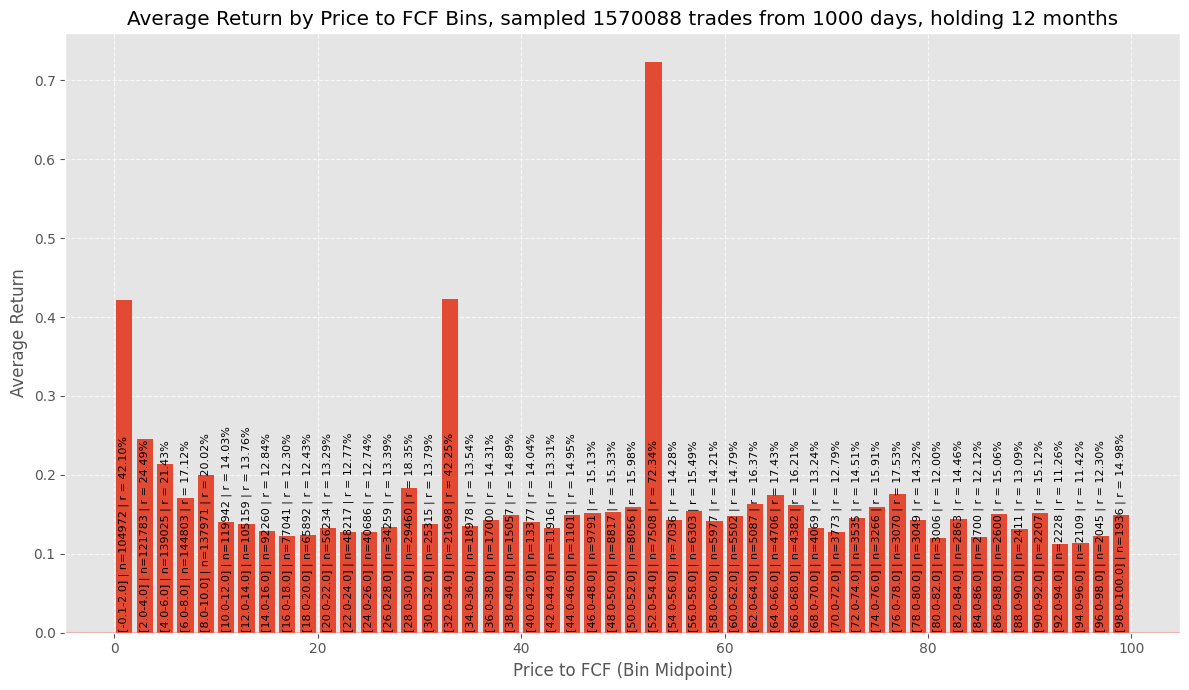

In [212]:
z = sample
# Define number of bins
BIN_NUM = 50

# Create bins based on price_to_fcf
bins = pd.cut(z.price_to_fcf, bins=BIN_NUM)

# Calculate average return for each bin
bin_returns = z.groupby(bins, observed=False)['r'].mean().reset_index()

# Get the bin midpoints for x-axis
bin_returns['midpoint'] = bin_returns['price_to_fcf'].apply(lambda x: (x.left + x.right) / 2)

# Plot
plt.figure(figsize=(12, 7))
bars = plt.bar(bin_returns['midpoint'], bin_returns['r'], width=(z.price_to_fcf.max()-z.price_to_fcf.min())/BIN_NUM*0.8)

# Add text labels for bin boundaries
for i, bar in enumerate(bars):
    bin_range = bin_returns['price_to_fcf'].iloc[i]
    plt.text(bar.get_x() + bar.get_width()/2, 
            0.001, 
            f'[{bin_range.left:.1f}-{bin_range.right:.1f}] | n={len(z[bins==bin_range])} | r = {bin_returns["r"].iloc[i] * 100:.2f}%', 
            ha='center', 
            va='bottom', 
            rotation=90, 
            fontsize=8)

plt.title(f'Average Return by Price to FCF Bins, sampled {len(z)} trades from {len(random_indices)} days, holding 12 months')
plt.xlabel('Price to FCF (Bin Midpoint)')
plt.ylabel('Average Return')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

## The superpower of mean reversion from the ultra losers

According to a [research](https://journals.sagepub.com/doi/10.1177/0148558X221091803), momentum compensates the prediction power of free FCF. Specifically, they proposed to long high FCF & strong momentum stocks and short low FCF & negative momentum stocks. They claim this strategy has very good performance.

However, my data suggest being cheap has the biggest gain again. The most obvious pattern is the **strong mean reversion power** from those cigarette butts. Gain from Ben Graham's idea dwarfs everything else here. Therefore, both price to FCF (valuation) and momentum indicate we should buy market losers.

This pattern seems consistent with different momentum metrics scales. This can be tested by changing MAX_LOG_RETURN. 

In [213]:
start_dates = pd.date_range(start='2002-01-01', end='2023-10-01').to_list()
random_indices = np.random.choice(len(start_dates), size=1000, replace=False)

logging.getLogger('InterdayTrading').setLevel(logging.CRITICAL)

tr = trange(len(random_indices))
samples = []
for i in tr:
    day = pd.to_datetime(start_dates[random_indices[i]])

    while not t._is_trading_day(day.date()):    
        day += pd.DateOffset(days=1)

    end_date = day + pd.DateOffset(months=12)

    while not t._is_trading_day(end_date.date()):
        end_date += pd.DateOffset(days=1)

    end_date = end_date.strftime('%Y-%m-%d')

    d = t.build_features_for_date(day.date(), skip_signals={'revenue_growth', 'price_to_fcf', 'operation_margin'})
    x = d[~d['industry'].str.contains('REIT', case=False, na=False)]

    x.set_index('symbol', inplace=True)

    sym = x.index.to_list()
    p = Dataset(sym, {'adjusted_close': 'end_price'}, for_date=end_date).data.set_index('symbol')
    y = pd.merge(x, p, on='symbol', how = 'inner', suffixes=('_begin', '_end'))
    y['r'] = y.end_price / y.price - 1

    z = y[['r', 'price', 'm3', 'm6', 'm9', 'm12', 'date_begin', 'date_end']].reset_index(drop=False)
    samples.append(z)




100%|██████████| 1000/1000 [06:50<00:00,  2.44it/s]


In [214]:
# Filter out simples w/o full price momentum history

z = pd.concat(samples)
z.replace([np.inf, -np.inf], np.nan, inplace=True)
z = z[~(z.m3.isna() | z.m6.isna() | z.m9.isna() | z.m12.isna())]

z['m3'] = np.log(z['m3'] + 1)
z['m6'] = np.log(z['m6'] + 1)
z['m9'] = np.log(z['m9'] + 1)
z['m12'] = np.log(z['m12'] + 1)
z.describe()

,r,price,m3,m6,m9,m12
count,2.594659e+06,2.594659e+06,2.594659e+06,2.594659e+06,2.594659e+06,2.594659e+06
mean,7.668943e-01,3.122781e+10,-1.659009e-04,-1.970321e-03,-1.897706e-03,-9.145302e-03
std,1.676476e+02,3.144558e+12,2.957909e-01,4.149781e-01,5.145352e-01,6.049231e-01
min,-9.999997e-01,1.000000e-04,-9.672912e+00,-1.330468e+01,-1.422098e+01,-1.491412e+01
25%,-1.773585e-01,7.730000e+00,-1.029160e-01,-1.476503e-01,-1.829257e-01,-2.184456e-01
50%,7.086224e-02,1.750000e+01,1.712205e-02,2.963180e-02,4.352231e-02,5.340705e-02
75%,3.292862e-01,3.904000e+01,1.234419e-01,1.798973e-01,2.294337e-01,2.730833e-01
max,2.098532e+05,7.839186e+14,1.133938e+01,1.313014e+01,1.313014e+01,1.721306e+01


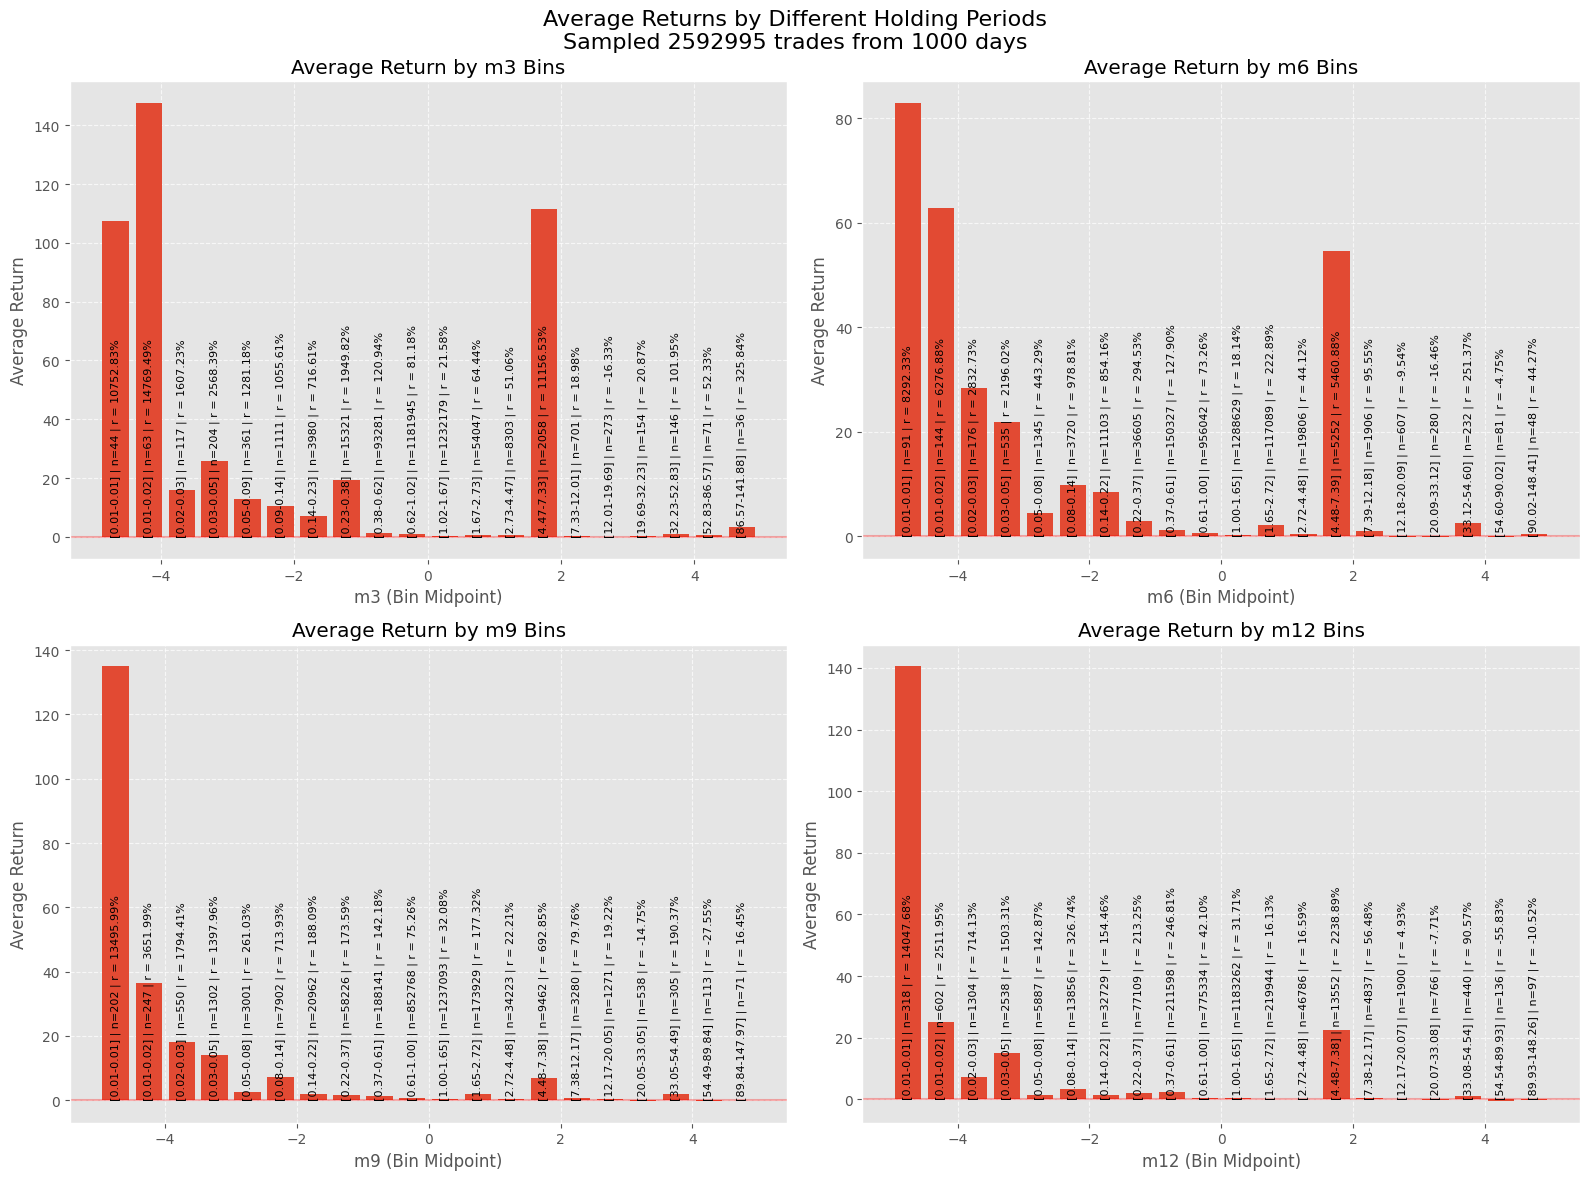

In [ ]:
# Define number of bins
BIN_NUM = 20


# Plot 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

MAX_LOG_RETURN = 5

for idx, metric in enumerate(['m3', 'm6', 'm9', 'm12']):
    # Create bins for this metric
    z = z[z[metric].abs().between(0, MAX_LOG_RETURN)]
    bins = pd.cut(z[metric], bins=BIN_NUM)
    
    # Calculate average return for each bin
    bin_returns = z.groupby(bins, observed=False)['r'].mean().reset_index()
    
    # Get the bin midpoints for x-axis
    bin_returns['midpoint'] = bin_returns[metric].apply(lambda x: (x.left + x.right) / 2)
    
    # Plot on the corresponding subplot
    bars = axes[idx].bar(bin_returns['midpoint'], bin_returns['r'], 
                            width=(z[metric].max()-z[metric].min())/BIN_NUM*0.8)
    
    # Add text labels for bin boundaries and data counts
    for i, bar in enumerate(bars):
        bin_range = bin_returns[metric].iloc[i]
        count = len(z[z[metric].between(bin_range.left, bin_range.right, inclusive='both')])
        axes[idx].text(bar.get_x() + bar.get_width()/2, 
            0.001, 
            f'[{np.exp(bin_range.left):.2f}-{np.exp(bin_range.right):.2f}] | n={count} | r = {bin_returns["r"].iloc[i] * 100:.2f}%', 
            ha='center', 
            va='bottom', 
            rotation=90, 
            fontsize=8)
    
    axes[idx].set_title(f'Average Return by {metric} Bins')
    axes[idx].set_xlabel(f'{metric} (Bin Midpoint)')
    axes[idx].set_ylabel('Average Return')
    axes[idx].grid(True, linestyle='--', alpha=0.7)
    axes[idx].axhline(y=0, color='r', linestyle='-', alpha=0.3)

plt.suptitle(f'Sampled {len(z)} trades from {len(random_indices)} days', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Profitability: moderate prediction power, bimodal

The prediction power from profitability – we use operating margin to mearsure – is moderate compared to price to fcf multiple and price momentum. The top winner group has less than 100% return, unlike the astronomical numbers from the previous signals.

Another interesting property is bimodal: the winners are either very unprofitable (-80% operating margin) or very profitable (120% operating margin).

In [226]:
start_dates = pd.date_range(start='2002-01-01', end='2023-10-01').to_list()
random_indices = np.random.choice(len(start_dates), size=1000, replace=False)

logging.getLogger('InterdayTrading').setLevel(logging.CRITICAL)

tr = trange(len(random_indices))
samples = []
for i in tr:
    day = pd.to_datetime(start_dates[random_indices[i]])

    while not t._is_trading_day(day.date()):    
        day += pd.DateOffset(days=1)

    end_date = day + pd.DateOffset(months=12)

    while not t._is_trading_day(end_date.date()):
        end_date += pd.DateOffset(days=1)

    end_date = end_date.strftime('%Y-%m-%d')

    d = t.build_features_for_date(day.date(), skip_signals={'revenue_growth', 'price_to_fcf', 'momentum'})
    x = d[~d['industry'].str.contains('REIT', case=False, na=False)]

    x.set_index('symbol', inplace=True)

    sym = x.index.to_list()
    p = Dataset(sym, {'adjusted_close': 'end_price'}, for_date=end_date).data.set_index('symbol')
    y = pd.merge(x, p, on='symbol', how = 'inner', suffixes=('_begin', '_end'))
    y['r'] = y.end_price / y.price - 1

    z = y[['r', 'price', 'opm_3m', 'opm_6m', 'opm_9m', 'opm_12m', 'date_begin', 'date_end']].reset_index(drop=False)
    samples.append(z)


100%|██████████| 1000/1000 [46:41<00:00,  2.80s/it] 


In [227]:
z = pd.concat(samples)
z.replace([np.inf, -np.inf], np.nan, inplace=True)
z = z[~(z.opm_3m.isna() | z.opm_6m.isna() | z.opm_9m.isna() | z.opm_12m.isna())]
z.describe()

,r,price,opm_3m,opm_6m,opm_9m,opm_12m
count,2.634262e+06,2.634745e+06,2.703144e+06,2.703144e+06,2.703144e+06,2.703144e+06
mean,2.655933e-01,3.457594e+10,-3.157841e+09,-3.400749e+09,-3.643660e+09,-2.672031e+09
std,2.628516e+01,3.491045e+12,9.620851e+11,9.984024e+11,1.033444e+12,8.849903e+11
min,-9.999997e-01,0.000000e+00,-3.122563e+14,-3.122563e+14,-3.122563e+14,-3.122563e+14
25%,-2.162468e-01,8.200000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.683598e-02,1.810000e+01,7.875492e-02,7.877302e-02,7.849252e-02,7.810271e-02
75%,3.125923e-01,4.006000e+01,2.019550e-01,2.018692e-01,2.011526e-01,2.004895e-01
max,1.937647e+04,8.221163e+14,2.359244e+08,2.359244e+08,2.359244e+08,2.359244e+08


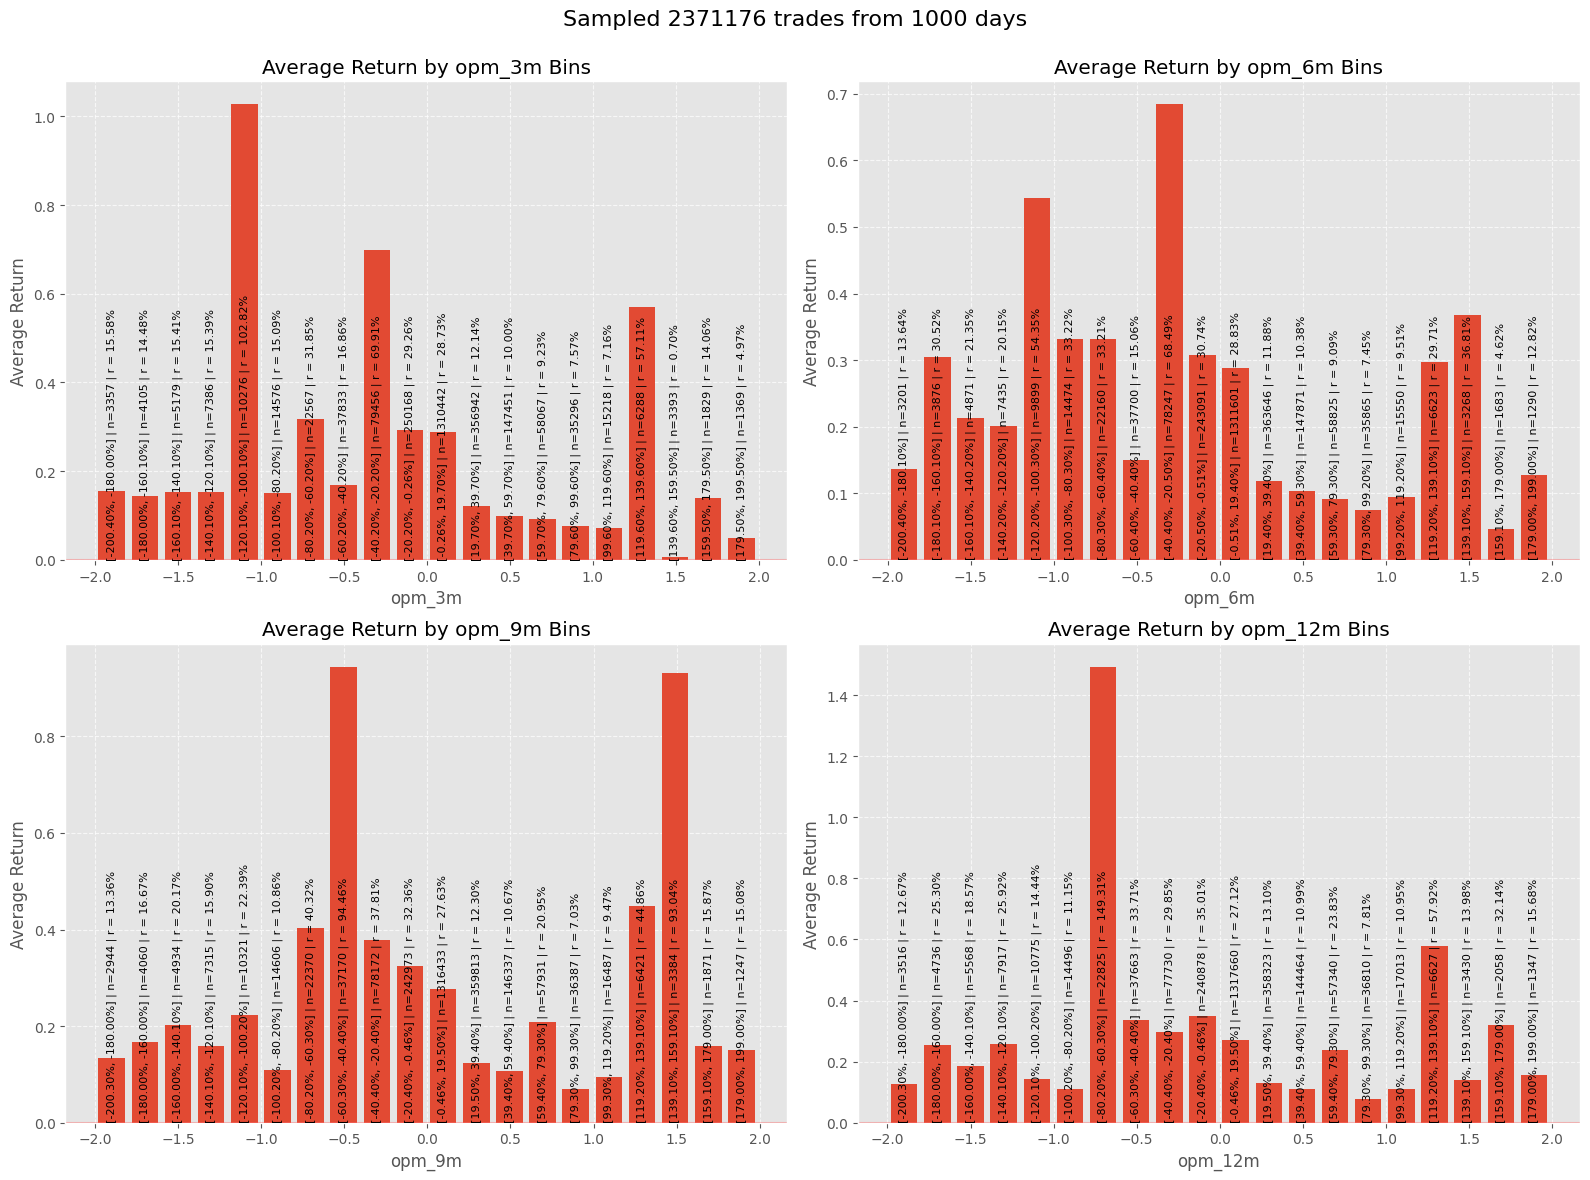

In [231]:
# Define number of bins
BIN_NUM = 20


# Plot 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

MAX_OPM = 2.0

for idx, metric in enumerate(['opm_3m', 'opm_6m', 'opm_9m', 'opm_12m']):
    # Create bins for this metric
    z = z[z[metric].abs().between(0, MAX_OPM)]
    bins = pd.cut(z[metric], bins=BIN_NUM)
    
    # Calculate average return for each bin
    bin_returns = z.groupby(bins, observed=False)['r'].mean().reset_index()
    
    # Get the bin midpoints for x-axis
    bin_returns['midpoint'] = bin_returns[metric].apply(lambda x: (x.left + x.right) / 2)
    
    # Plot on the corresponding subplot
    bars = axes[idx].bar(bin_returns['midpoint'], bin_returns['r'], 
                            width=(z[metric].max()-z[metric].min())/BIN_NUM*0.8)
    
    # Add text labels for bin boundaries and data counts
    for i, bar in enumerate(bars):
        bin_range = bin_returns[metric].iloc[i]
        count = len(z[z[metric].between(bin_range.left, bin_range.right, inclusive='both')])
        axes[idx].text(bar.get_x() + bar.get_width()/2, 
            0.001, 
            f'[{bin_range.left*100:.2f}%, {bin_range.right*100:.2f}%] | n={count} | r = {bin_returns["r"].iloc[i] * 100:.2f}%', 
            ha='center', 
            va='bottom', 
            rotation=90, 
            fontsize=8)
    
    axes[idx].set_title(f'Average Return by {metric} Bins')
    axes[idx].set_xlabel(f'{metric}')
    axes[idx].set_ylabel('Average Return')
    axes[idx].grid(True, linestyle='--', alpha=0.7)
    axes[idx].axhline(y=0, color='r', linestyle='-', alpha=0.3)

plt.suptitle(f'Sampled {len(z)} trades from {len(random_indices)} days', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Revenue growth

In [239]:
start_dates = pd.date_range(start='2002-01-01', end='2023-10-01').to_list()
random_indices = np.random.choice(len(start_dates), size=1000, replace=False)

logging.getLogger('InterdayTrading').setLevel(logging.CRITICAL)

tr = trange(len(random_indices))
samples = []
for i in tr:
    day = pd.to_datetime(start_dates[random_indices[i]])

    while not t._is_trading_day(day.date()):    
        day += pd.DateOffset(days=1)

    end_date = day + pd.DateOffset(months=12)

    while not t._is_trading_day(end_date.date()):
        end_date += pd.DateOffset(days=1)

    end_date = end_date.strftime('%Y-%m-%d')

    d = t.build_features_for_date(day.date(), skip_signals={'operation_margin', 'price_to_fcf', 'momentum'})
    x = d[~d['industry'].str.contains('REIT', case=False, na=False)]

    x.set_index('symbol', inplace=True)

    sym = x.index.to_list()
    p = Dataset(sym, {'adjusted_close': 'end_price'}, for_date=end_date).data.set_index('symbol')
    y = pd.merge(x, p, on='symbol', how = 'inner', suffixes=('_begin', '_end'))
    y['r'] = y.end_price / y.price - 1

    z = y[['r', 'price', 'median_yoy', 'min_yoy', 'last_yoy', 'date_begin', 'date_end']].reset_index(drop=False)
    samples.append(z)
        

100%|██████████| 1000/1000 [53:06<00:00,  3.19s/it] 


In [259]:
z = pd.concat(samples)
z.replace([np.inf, -np.inf], np.nan, inplace=True)
z = z[~(z.median_yoy.isna() | z.min_yoy.isna() | z.last_yoy.isna())]
#z = z[(z.median_yoy.abs() < 10) & (z.min_yoy.abs() < 2) & (z.last_yoy.abs() < 2)]


# z['median_yoy'] = np.log(z['median_yoy'] + 1)
# z['min_yoy'] = np.log(z['min_yoy'] + 1)
# z['last_yoy'] = np.log(z['last_yoy'] + 1)

z.describe()

,r,price,median_yoy,min_yoy,last_yoy
count,2.028911e+06,2.029362e+06,2.050133e+06,2.050133e+06,2.050133e+06
mean,2.008387e-01,2.100657e+10,9.949192e+00,-3.822185e+01,2.057153e+03
std,2.715904e+00,2.028676e+12,2.000791e+03,8.235724e+03,1.076874e+06
min,-9.999960e-01,0.000000e+00,-7.194245e+00,-1.798231e+06,-1.798231e+06
25%,-1.535777e-01,8.400000e+00,-1.685869e-02,-1.684507e-01,-3.458589e-02
50%,7.877462e-02,1.804888e+01,7.242750e-02,-2.094607e-02,6.930169e-02
75%,3.289699e-01,3.840000e+01,2.024745e-01,7.149555e-02,2.135299e-01
max,7.944192e+02,5.548284e+14,8.389825e+05,1.740905e+03,5.827506e+08


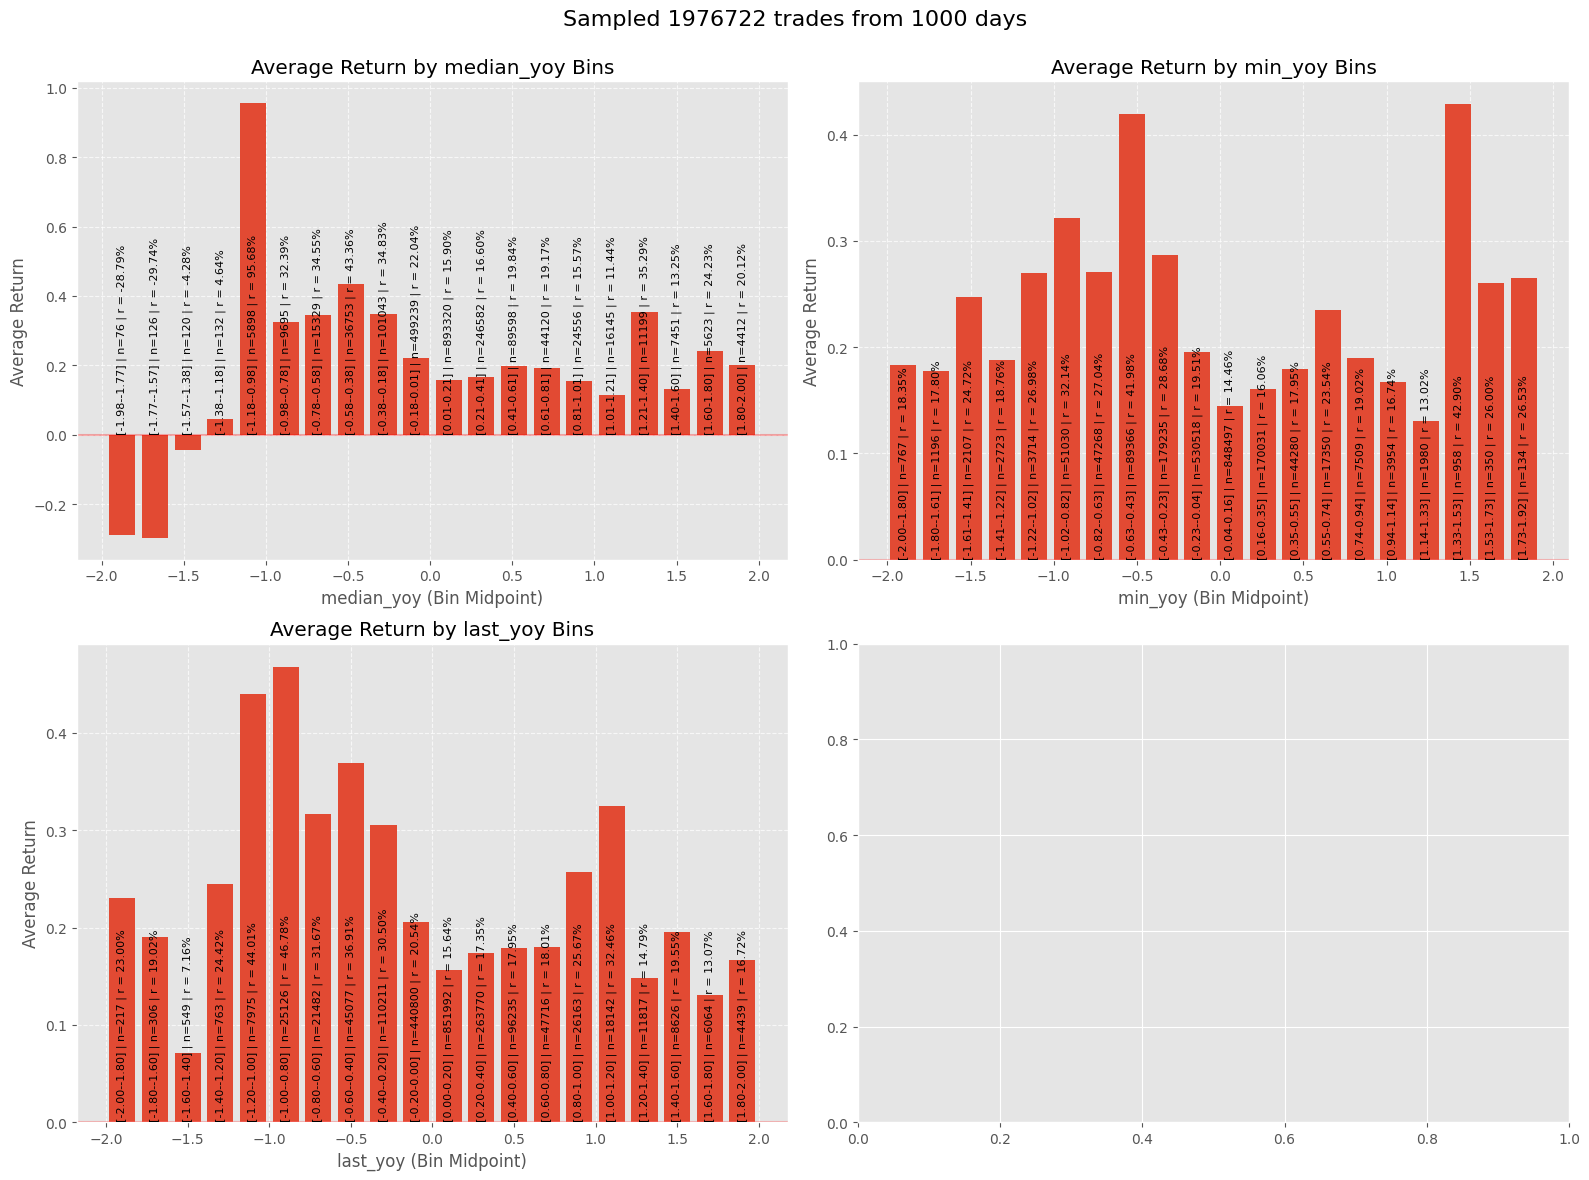

In [262]:
# Define number of bins
BIN_NUM = 20


# Plot 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

MAX_YOY = 2

for idx, metric in enumerate(['median_yoy', 'min_yoy', 'last_yoy']):
    # Create bins for this metric
    z = z[z[metric].abs().between(0, MAX_YOY)]
    bins = pd.cut(z[metric], bins=BIN_NUM)
    
    # Calculate average return for each bin
    bin_returns = z.groupby(bins, observed=False)['r'].mean().reset_index()
    
    # Get the bin midpoints for x-axis
    bin_returns['midpoint'] = bin_returns[metric].apply(lambda x: (x.left + x.right) / 2)
    
    # Plot on the corresponding subplot
    bars = axes[idx].bar(bin_returns['midpoint'], bin_returns['r'], 
                            width=(z[metric].max()-z[metric].min())/BIN_NUM*0.8)
    
    # Add text labels for bin boundaries and data counts
    for i, bar in enumerate(bars):
        bin_range = bin_returns[metric].iloc[i]
        count = len(z[z[metric].between(bin_range.left, bin_range.right, inclusive='both')])
        axes[idx].text(bar.get_x() + bar.get_width()/2, 
            0.001, 
            f'[{bin_range.left:.2f}-{bin_range.right:.2f}] | n={count} | r = {bin_returns["r"].iloc[i] * 100:.2f}%', 
            ha='center', 
            va='bottom', 
            rotation=90, 
            fontsize=8)
    
    axes[idx].set_title(f'Average Return by {metric} Bins')
    axes[idx].set_xlabel(f'{metric} (Bin Midpoint)')
    axes[idx].set_ylabel('Average Return')
    axes[idx].grid(True, linestyle='--', alpha=0.7)
    axes[idx].axhline(y=0, color='r', linestyle='-', alpha=0.3)

plt.suptitle(f'Sampled {len(z)} trades from {len(random_indices)} days', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Buy & Hold for 1 year, naive strategy

In [2]:
import logging
from tqdm import trange
# Set logger level to critical during this execution
logging.getLogger('InterdayTrading').setLevel(logging.CRITICAL)

t = InterdayTrading('2024-01-02', '2024-01-15')

# Generate 100 random dates
start_dates = pd.date_range(start='2009-01-01', end='2023-10-01').to_list()
random_indices = np.random.choice(len(start_dates), size=100, replace=False)
hist = []
ret = []
tr = trange(len(random_indices))
for i in tr:
    # Ensure start_date is a trading day
    start_date = pd.to_datetime(start_dates[random_indices[i]])
    while not t._is_trading_day(start_date.date()):
        start_date += pd.Timedelta(days=1)
    start_date = start_date.strftime('%Y-%m-%d')

    # Ensure end_date is a trading day
    end_date = pd.to_datetime(start_date) + pd.DateOffset(months=12)
    while not t._is_trading_day(end_date.date()):
        end_date += pd.Timedelta(days=1)
    end_date = end_date.strftime('%Y-%m-%d')

    d = t.build_features_for_date(pd.to_datetime(start_date).date())

    ####  Filtering Algorithm Begin ####
    
    # Filter out REITs
    x = d[~d['industry'].str.contains('REIT', case=False, na=False)]

    # Filter out negative FCF
    x = x[(x.min_fcf > 0) & (x.last_fcf > x.free_cash_flow / 4) & (x.price_to_fcf < 5.0) & (x.price_to_fcf > 2.0)]

    # Filter out negative 3-month price return
    # x = x[(x.m3 > 0.05) & (x.m3 < x.m6) & (x.m6 < x.m9) & (x.m9 < x.m12)]

    # # Filter out low-priced stocks
    # x = x[x.price > 5]

    # Filter out stocks by revenue growth
    # x = x[(x.last_yoy > 0.2) & (x.min_yoy > 0.05)]
    
    x['rank'] = x.price_to_fcf

    ####  Filtering Algorithm End ####

    sym = x.symbol.to_list()
    p = Dataset(sym, {'adjusted_close': 'end_price'}, for_date=end_date).data
    y = pd.merge(x, p[['symbol', 'end_price']], on='symbol', how = 'inner')
    y['r'] = y.end_price / y.price - 1
    spx_r = pl.get_price('^SPX', end_date) / pl.get_price('^SPX', start_date) - 1

    portfolio = y.sort_values('rank').head(10)
    portfolio['spx_r'] = spx_r
    portfolio['diff'] = portfolio.r - portfolio.spx_r
    portfolio['start_date'] = start_date
    
    hist.append(portfolio)
    for _, stock in portfolio.iterrows():
        ret.append(stock['diff'])
        #print(f"[{i+1}] {stock['symbol']} {start_date} {stock['spx_r']:.2f} {stock['diff']:.2f}")
    tr.set_description(f"VS SP500: {np.mean(ret)*100:.2f}%  ")

hist = pd.concat(hist)



VS SP500: 7.89%  : 100%|██████████| 100/100 [12:49<00:00,  7.69s/it]


In [3]:
ranges = [(i/10, (i+1)/10) for i in range(80)]
for start, end in ranges:
    subset = hist[hist['diff'].abs().between(start, end, inclusive='both')]
    if not subset.empty:
        mean_diff = subset['diff'].mean()
        print(f"Range [{start:.1f}, {end:.1f}]: Mean diff = {mean_diff:.4f}, Count = {len(subset)}")



Range [0.0, 0.1]: Mean diff = -0.0049, Count = 264
Range [0.1, 0.2]: Mean diff = -0.0413, Count = 220
Range [0.2, 0.3]: Mean diff = -0.0070, Count = 159
Range [0.3, 0.4]: Mean diff = -0.0650, Count = 123
Range [0.4, 0.5]: Mean diff = -0.0777, Count = 61
Range [0.5, 0.6]: Mean diff = 0.1208, Count = 48
Range [0.6, 0.7]: Mean diff = 0.0989, Count = 35
Range [0.7, 0.8]: Mean diff = 0.3266, Count = 24
Range [0.8, 0.9]: Mean diff = 0.3375, Count = 10
Range [0.9, 1.0]: Mean diff = 0.4897, Count = 4
Range [1.0, 1.1]: Mean diff = 0.2880, Count = 11
Range [1.1, 1.2]: Mean diff = 0.7697, Count = 6
Range [1.2, 1.3]: Mean diff = 1.2497, Count = 4
Range [1.3, 1.4]: Mean diff = 1.3446, Count = 5
Range [1.4, 1.5]: Mean diff = 1.4494, Count = 7
Range [1.5, 1.6]: Mean diff = 1.5255, Count = 3
Range [1.6, 1.7]: Mean diff = 1.6459, Count = 3
Range [1.8, 1.9]: Mean diff = 1.8507, Count = 2
Range [2.1, 2.2]: Mean diff = 2.1247, Count = 1
Range [2.3, 2.4]: Mean diff = 2.3425, Count = 1
Range [2.4, 2.5]: Mea

In [4]:
hist['spx_r'].describe()

count    1000.000000
mean        0.160240
std         0.128787
min        -0.177817
25%         0.094531
50%         0.150720
75%         0.216628
max         0.665984
Name: spx_r, dtype: float64

In [172]:
pd.set_option('display.max_rows', None)
hist[hist['diff'].abs().between(0.4, 0.5, inclusive='both')].sort_values(by='diff', ascending=False)[['symbol', 'price_to_fcf', 'm3', 'm6', 'm9', 'm12', 'median_yoy', 'min_yoy', 'last_yoy',  'price', 'spx_r', 'diff']]

,symbol,price_to_fcf,m3,m6,m9,m12,median_yoy,min_yoy,last_yoy,price,spx_r,diff
0,MOMO,1.360641,-0.314309,-0.320048,-0.267811,0.385865,3.971074,2.224236,2.224236,17.06,0.026728,0.482650
1,WIT,0.813752,-0.189055,-0.419929,-0.465574,-0.454849,0.350381,0.282207,0.381204,1.63,0.099099,0.453049
0,BMA,0.008995,-0.216159,0.163551,0.380776,0.266102,2.035362,0.869133,5.091246,14.94,0.098098,0.441393
0,BWMX,0.637336,1.786604,1.739663,1.495119,1.566714,0.258112,0.190912,0.820944,17.89,0.108549,0.439243
0,BWMX,0.759530,0.646332,2.449838,2.336463,2.058824,0.258112,0.190912,0.820944,21.32,0.072415,0.413045
2,YRD,0.835838,0.134245,-0.179853,0.035136,1.076994,1.380861,1.320164,1.320164,22.39,0.040334,0.402720
2,SSBI,1.951052,0.094488,0.535912,0.404040,0.163180,0.194506,0.134328,0.398706,2.78,0.104752,-0.421299
0,AR,1.137579,-0.358537,-0.448059,-0.716900,-0.748806,0.369174,0.179270,0.337088,5.26,-0.028725,-0.440857
3,YRD,0.634151,-0.241483,-0.241689,-0.216939,0.267304,0.715222,0.612253,0.703644,27.83,0.045253,-0.450212
1,QD,0.995999,NaN,NaN,NaN,NaN,3.096354,1.083887,1.083887,9.64,0.038126,-0.458251


In [22]:
len(pd.date_range(start='2009-01-01', end='2023-10-01').to_list()) * 2/3

3591.3333333333335

count    1000.000000
mean        0.024739
std         0.290339
min        -0.660318
25%        -0.103945
50%        -0.004035
75%         0.088228
max         3.991851
Name: diff, dtype: float64

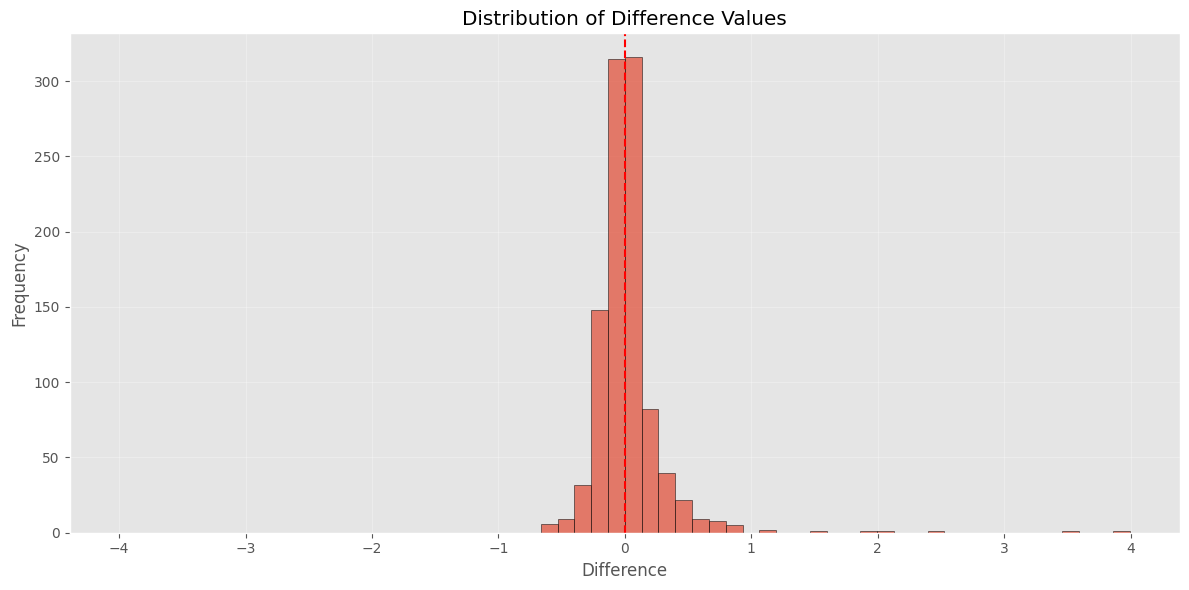

In [129]:
plt.figure(figsize=(12, 6))
m = max(abs(hist['diff'].min()), abs(hist['diff'].max()))
n, bins, patches = plt.hist(hist['diff'], bins=60, range=(-m, m), edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribution of Difference Values')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
hist['diff'].describe()

In [134]:
hist.columns

Index(['symbol', 'free_cash_flow', 'min_fcf', 'last_fcf', 'price',
       'price_to_fcf', 'median_yoy', 'min_yoy', 'last_yoy', 'm3', 'm6', 'm9',
       'm12', 'sector', 'industry', 'date', 'rank', 'end_price', 'r', 'spx_r',
       'diff', 'start_date'],
      dtype='object')

# Sandbox

Let's try find some good combination of filters. 

In [119]:
logging.getLogger('InterdayTrading').setLevel(logging.INFO)

day = '2010-01-11'
end_date = (pd.to_datetime(day) + pd.DateOffset(months=3)).strftime('%Y-%m-%d')

while not t._is_trading_day(pd.to_datetime(end_date).date()):
    end_date = (pd.to_datetime(end_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

d = t.build_features_for_date(pd.to_datetime(day).date())
x = d[~d['industry'].str.contains('REIT', case=False, na=False)]

# Filter out negative FCF
x = x[(x.min_fcf > 0) & (x.last_fcf > x.free_cash_flow / 4) & (x.price_to_fcf < 3)]

# Filter out negative 3-month price return
x = x[x.m12 > 0]

# Filter out low-priced stocks
x = x[x.price > 1]

# Filter out stocks by revenue growth
x = x[(x.last_yoy > 0.1) & (x.min_yoy > 0.01)]

x['rank'] = x.price_to_fcf

####  Filtering Algorithm End ####

sym = x.symbol.to_list()
p = Dataset(sym, {'adjusted_close': 'end_price'}, for_date=end_date).data
y = pd.merge(x, p[['symbol', 'end_price']], on='symbol', how = 'inner')
y['r'] = y.end_price / y.price - 1
y.sort_values('r') 


2025-04-24 12:33:52,224 - Fetching price data for 5389 stocks on 2010-01-11


2025-04-24 12:33:52,505 - Retrieved prices for 2337 stocks
2025-04-24 12:33:52,506 - Calculating price-to-FCF ratios
2025-04-24 12:33:52,541 - Calculating revenue growth metrics
2025-04-24 12:33:54,872 - Calculating price momentum metrics
2025-04-24 12:33:54,872 - Calculating price momentum for 5389 stocks
2025-04-24 12:33:55,338 - Calculated price momentum for 2288 stocks
2025-04-24 12:33:55,338 - Merging feature data
2025-04-24 12:33:55,341 - Adding sector and industry information


,symbol,free_cash_flow,min_fcf,last_fcf,price,price_to_fcf,median_yoy,min_yoy,last_yoy,m3,m6,m9,m12,sector,industry,date,rank,end_price,r
6,VZ,4.768748,1.013732,1.627948,14.230000,2.984012,0.107491,0.033767,0.101527,0.114330,0.119591,0.051737,0.052515,Communication Services,Telecom Services,2010-01-11,2.984012,13.57000,-0.046381
1,GRVY,156.859359,156.859359,156.859359,7.440000,0.047431,0.196349,0.057255,0.129398,-0.088235,0.240000,0.878788,2.444444,Communication Services,Electronic Gaming & Multimedia,2010-01-11,0.047431,8.04000,0.080645
2,KOF,96.446969,21.386407,27.435689,39.260000,0.407063,0.311103,0.306602,0.315478,0.141611,0.474831,0.645432,0.596584,Consumer Defensive,Beverages—Non-Alcoholic,2010-01-11,0.407063,42.63000,0.085838
5,TEO,9.060686,0.596809,3.059271,9.247622,1.020632,0.137093,0.085583,0.134886,0.031144,0.401847,1.296343,0.972915,Communication Services,Telecom Services,2010-01-11,1.020632,10.41056,0.125755
0,FMX,389.358038,12.830899,376.527139,33.210000,0.085294,0.195402,0.177417,0.213887,-0.004795,0.280262,0.506806,0.483251,Consumer Defensive,Beverages - Brewers,2010-01-11,0.085294,37.65000,0.133695
3,NVO,4.120302,0.683800,1.422535,5.500000,1.334853,0.162474,0.113936,0.113936,0.055662,0.233184,0.532033,0.291080,Healthcare,Drug Manufacturers - General,2010-01-11,1.334853,6.59000,0.198182
4,RGR,1.861176,0.350118,0.618466,5.250000,2.820797,0.709756,0.494589,0.702119,-0.146341,-0.182243,-0.062500,0.661392,Industrials,Aerospace & Defense,2010-01-11,2.820797,6.77000,0.289524


In [21]:
len(start_dates)

NameError: name 'start_dates' is not defined

In [1]:
x = InterdayTrading('2009-01-02', '2024-01-15')

NameError: name 'InterdayTrading' is not defined

In [8]:
price_cache = Dataset(t.stocks.symbol.tolist(), {'high': 'high_price', 'low': 'low_price'}).data

In [14]:
price_cache.set_index(['symbol', 'date'], inplace=True)

high_price    128.66
low_price     125.08
Name: (AAPL, 2023-01-04), dtype: float64

# Sandbox

## Run the strategy on one day's price value

In [ ]:
start_date = '2022-04-05'
end_date = (pd.to_datetime(start_date) + pd.DateOffset(months=3)).strftime('%Y-%m-%d')

d = t.build_features_for_date(pd.to_datetime(start_date).date())
x = d
x = d[~d['industry'].str.contains('REIT', case=False, na=False)]
x = x[(x.min_fcf > 0) & (x.last_fcf > x.free_cash_flow / 4)]

#x = x[(x.min_yoy > 0)]

x['rank'] = x.price_to_fcf
#x = x[x.price >= 10]
sym = x.symbol.to_list()
p = Dataset(sym, {'adjusted_close': 'end_price'}, for_date=end_date).data
y = pd.merge(x, p[['symbol', 'end_price']], on='symbol', how = 'inner')
y['r'] = y.end_price / y.price - 1
spx_r = pl.get_price('^SPX', end_date) / pl.get_price('^SPX', start_date) - 1

portfolio = y.sort_values('rank').head(10)

print(f"Average return: {portfolio.r.mean()*100:.2f}%, SPX return: {spx_r*100:.2f}%, diff: {(portfolio.r.mean() - spx_r)*100:.2f}%")
y[['symbol', 'last_fcf', 'price_to_fcf', 'median_yoy', 'min_yoy', 'last_yoy', 'sector', 'industry', 'rank', 'r']].sort_values('rank').head(20)